In [43]:
import numpy as np
import pandas as pd 
import re 
from nltk.corpus import stopwords
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell_Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [21]:
reviews = pd.read_csv("news_summary.csv")
reviews.drop(['read_more','date','ctext','author'],inplace=True,axis=1)
print(reviews.shape)
reviews.head()
# reviews = pd.read_csv('Reviews.csv')
# reviews.drop(['Time','Score','HelpfulnessDenominator','HelpfulnessNumerator','ProfileName','UserId','ProductId','Id'],axis=1,inplace=True)
# reviews.rename({'Summary':'headlines','Text':'text'},axis=1,inplace=True)
# reviews.head()

(4514, 2)


,headlines,text
0,Daman & Diu revokes mandatory Rakshabandhan in offices order,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...
1,Malaika slams user who trolled her for 'divorcing rich man',"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS' form,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini..."
3,Aaj aapne pakad liya: LeT man Dujana before being killed,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a..."
4,Hotel staff to get training to spot signs of sex trafficking,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph..."


In [22]:
reviews.isnull().sum()

headlines    0
text         0
dtype: int64

In [23]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [24]:
cleaned_headlines = []
cleaned_text = []

for headlines in reviews['headlines']:
    cleaned_headlines.append(clean_text(headlines, remove_stopwords=True))
print("Headlines are complete.")

for text in reviews['text']:
    cleaned_text.append(clean_text(text))
print("Texts are complete.")

Headlines are complete.
Texts are complete.


In [25]:
for i in range(4):
    print("Headlines: ",i+1) 
    print(cleaned_headlines[i])
    print('-'*80)
    print(cleaned_text[i])
    print()

Headlines:  1
daman diu revokes mandatory rakshabandhan offices order
--------------------------------------------------------------------------------
administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august 7 administration forced withdraw decision within 24 hours issuing circular received flak employees slammed social media

Headlines:  2
malaika slams user trolled 'divorcing rich man'
--------------------------------------------------------------------------------
malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacation user commented malaika responded certainly got get damn facts right spewing sh know nothing

Headlines:  3
'virgin' corrected 'unmarried' igims' form
--------------------------------------------------------------------------------
indira gandhi institute medical sciences igims patna thursday made corrections mari

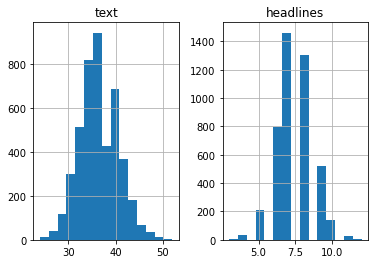

In [26]:
text_word_count = []
headlines_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_headlines:
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'headlines': headlines_word_count})
length_df.hist(bins=15)
plt.show()

In [27]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=55):
        count += 1
print(count/len(cleaned_text))

1.0


In [28]:
max_headlines_len=15
max_text_len=55

cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_headlines[i].split())<=max_headlines_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])


In [29]:
short_headlines[0]

'daman diu revokes mandatory rakshabandhan offices order'

In [30]:
df=pd.DataFrame({'text':short_text,'headlines':short_headlines})
df['headlines'][0]

'daman diu revokes mandatory rakshabandhan offices order'

In [31]:
len(df['headlines'])

4514

In [32]:

for i in range(len(df['headlines'])):
    df['headlines'][i] = 'sostok '+ df['headlines'][i] + ' eostok'
    
#     print(headline)
df['headlines']

0       sostok daman diu revokes mandatory rakshabandhan offices order eostok
1               sostok malaika slams user trolled 'divorcing rich man' eostok
2                    sostok 'virgin' corrected 'unmarried' igims' form eostok
3                    sostok aaj aapne pakad liya let man dujana killed eostok
4           sostok hotel staff get training spot signs sex trafficking eostok
                                        ...                                  
4509       sostok rasna seeking 250 cr revenue snack category chairman eostok
4510            sostok sachin attends rajya sabha questions attendance eostok
4511                     sostok rob childhood aamir kids reality shows eostok
4512         sostok asha bhosle gets 53 000 power bill unused bungalow eostok
4513                  sostok half india languages may die 50yrs survey eostok
Name: headlines, Length: 4514, dtype: object

In [33]:
# X = list(df['text'])
# y = list(df['headlines'])
X = df['text']
y = df['headlines']

x_tr,x_val,y_tr,y_val=train_test_split(X,y,test_size=0.3)

In [34]:
y_val

1619           sostok special section kohli opened cricket museum pune eostok
1853               sostok du college gets highest grade ugc assessment eostok
1597                        sostok grow hair says mahendra singh dhoni eostok
4436    sostok wanting msd bat crowd chants 'saurabh tiwary haye haye' eostok
704               sostok iron nail cutlet food floor cag railways food eostok
                                        ...                                  
453          sostok noida survey population density approving projects eostok
3140      sostok isi agents display kashmir banners ind pak tie report eostok
469                sostok finally taken stand ex bihar cm nitish kumar eostok
3173                         sostok peacock national bird sex hc judge eostok
4303          sostok 74 missing defence personnel may pak jails swaraj eostok
Name: headlines, Length: 1355, dtype: object

In [35]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(x_tr)

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer1 = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer1.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer1.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer1.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer1.num_words + 1

print(x_voc)

% of rare words in vocabulary: 69.6409652736904
Total Coverage of rare words: 15.15677025527192
5159


In [36]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(y_tr)

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


% of rare words in vocabulary: 88.4813210611803
Total Coverage of rare words: 36.83549033594891


In [37]:
 y_tokenizer.word_counts

OrderedDict([('sostok', 3159),
             ('take', 34),
             ('user', 5),
             ('privacy', 5),
             ('seriously', 3),
             ('airtel', 9),
             ('jio', 14),
             ('breach', 3),
             ('eostok', 3159),
             ('3', 61),
             ('4', 37),
             ('l', 2),
             ('cr', 43),
             ('evaded', 1),
             ('income', 2),
             ('deposited', 2),
             ('banks', 10),
             ('note', 19),
             ('ban', 43),
             ('maharashtra', 20),
             ('women', 54),
             ('jail', 24),
             ('staff', 20),
             ('allege', 3),
             ('sexual', 6),
             ('abuse', 3),
             ('seniors', 1),
             ('reported', 4),
             ('drowned', 1),
             ('punjab', 22),
             ('may', 40),
             ('fled', 1),
             ('mumbai', 80),
             ('akshay', 15),
             ('kumar', 31),
             ("'jolly", 

In [38]:
#prepare a tokenizer for reviews on training data
y_tokenizer1 = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer1.fit_on_texts(y_tr)

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer1.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer1.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headlines_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headlines_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer1.num_words +1


In [39]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [45]:
from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 110)      567490      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 200), (N 248800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
25/25 [==============================] - 302s 11s/step - loss: 3.6682 - val_loss: 2.0490
Epoch 2/50
25/25 [==============================] - 280s 11s/step - loss: 2.1458 - val_loss: 1.9476
Epoch 3/50
25/25 [==============================] - 221s 9s/step - loss: 2.0221 - val_loss: 1.8564
Epoch 4/50
25/25 [==============================] - 83s 3s/step - loss: 1.9398 - val_loss: 1.8333
Epoch 5/50
25/25 [==============================] - 87s 4s/step - loss: 1.8923 - val_loss: 1.8484
Epoch 6/50
25/25 [==============================] - 90s 4s/step - loss: 1.8912 - val_loss: 1.8101
Epoch 7/50
25/25 [==============================] - 92s 4s/step - loss: 1.8665 - val_loss: 1.8114
Epoch 8/50
25/25 [==============================] - 91s 4s/step - loss: 1.8446 - val_loss: 1.8003
Epoch 9/50
25/25 [==============================] - 92s 4s/step - loss: 1.8361 - val_loss: 1.8060
Epoch 10/50
25/25 [==============================] - 93s 4s/step - loss: 1.7860 - val_loss: 1.7979
Epoch 11/50
25

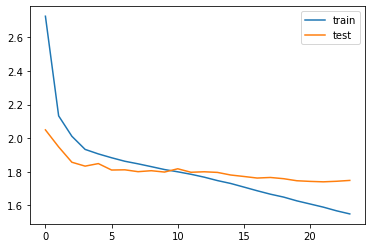

In [47]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [48]:
y_tokenizer1.word_index['sostok']

1

In [49]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [50]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [51]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [52]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [53]:
for i in range(len(x_val)):
    print('Review:',seq2text(x_val[i]))
    print('Original summary:',seq2summary(y_val[i]))
    print('Predicted summary:',decode_sequence(x_val[i].reshape(1,max_text_len)))
    print('\n')

Review: special section indian captain virat kohli opened cricket museum pune section kohli collection items including bat used double century new zealand october section also performance international cricket 
Original summary: special kohli cricket 
Predicted summary:  india


Review: none delhi university colleges managed get highest grade quality assessment conducted national assessment council body three 62 colleges secured second highest grade three colleges shri ram college commerce shri ram college women hindu college 
Original summary: du gets highest 
Predicted summary:  maha held held held lakh


Review: former india captain ms dhoni said go back old long look future never grow hair dhoni said asked change leadership burden former skipper long brown hair 2004 
Original summary: says singh dhoni 
Predicted summary:  india india india


Review: general said report food unfit human consumption served indian railways noted found served passenger found around added food items fou

Predicted summary:  world


Review: samajwadi party leader former cm akhilesh yadav uncle ram gopal yadav asked people give least six months newly elected cm yogi adityanath prove need start attacking first day said nothing objectionable yogi adityanath holding cm residence added 
Original summary: give yogi adityanath 6 months sp leader ram 
Predicted summary:  mamata asks mlas


Review: banned iran wearing festival 2017 15 year old brother also banned playing match israel first step dealing would every game played iran name iran said iranian official 
Original summary: bans 
Predicted summary:  china


Review: indian man singh singh convicted using fake identity american faces 10 years prison maximum possible fine 250 000 singh attempted false however attempt failed changed name details immigration n 
Original summary: indian using fake get us 
Predicted summary:  delhi metro


Review: brihanmumbai municipal corporation bmc issued notice ngo foundation data report stating third child

Predicted summary:  delhi man held delhi


Review: india captain virat kohli said singh selected limited overs squad middle order burden ms dhoni cannot leave much burden ms alone middle order needs one guy dhoni order case top order fire said kohli 
Original summary: dhoni virat kohli 
Predicted summary:  india india india


Review: commerce minister said number h visas indian come need get process something wanted added h non visa allows us companies foreign workers 
Original summary: indian come minister 
Predicted summary:  delhi metro


Review: three british jailed total 19 years helping 69 illegal afghan immigrants enter uk passports estimated 000 scam immigrants got uk gang passports passing others trying enter uk illegally 
Original summary: 3 uk 
Predicted summary:  india


Review: donald trump six month approval stands 36 lowest among us presidents last 70 years according national poll published sunday poll found 48 us citizens believe country leadership world billionaire too

Predicted summary:  india india


Review: one 2017 smartphones oneplus 5 expected launch june 15 primary camera according recent device 4 000 battery powered charge technology 8 gb ram gb internal first android 
Original summary: 5 launch 8 ram 
Predicted summary:  indian india


Review: tamil nadu government announced state film awards six consecutive years 2009 2014 best picture category films 2009 2010 2011 18 9 2012 2013 2014 received top awards last announced year 2008 
Original summary: tn announces state film 6 years 
Predicted summary:  delhi delhi


Review: government doctor district maharashtra allegedly beaten 26 year old pending salary received salary two months requested doctor look matter beat thursday fit first slapped police said 
Original summary: doctor salary maharashtra 
Predicted summary:  maha held 1 lakh


Review: 15 year old girl locked inside house east delhi krishna nagar two years mother matter came light informed delhi police raided house rescued girl girl m

Predicted summary:  maharashtra worth cr


Review: filmmaker said ranbir kapoor pictures sanjay dutt upcoming directorial come said pictures came shoot mumbai however added biopic made lot happiness film made happiness good 
Original summary: ranbir pics sanjay come 
Predicted summary:  man man


Review: 27 year old man arrested mumbai police saturday stabbed whose parents opposed marriage man reportedly woman house stabbed stomach stabbed man admitted government hospital arrested 
Original summary: mumbai man marriage 
Predicted summary:  man man man woman


Review: customers loss unauthorised electronic banking transactions reported within three days according rbi amount involved accounts concerned within 10 days rules third party neither bank customer system 
Original summary: report 3 days rbi 
Predicted summary:  1 crore worth crore


Review: actor kamal haasan appointed ambassador new team tamil fifth season pro league haasan added honoured sport take personal sport developed tho

Predicted summary:  india india


Review: afghanistan 19 cricket team set train chennai ahead 19 world cup held singapore next month earlier planned 19 team would sent noida afghan senior cricket team training base notably afghanistan recently awarded test status icc 
Original summary: train 
Predicted summary:  india india


Review: sunny deol tweeted picture sets son karan deol debut film pal pal ke sunny captioned picture work mode directing film karan debut film produced deol family production house films also launched father 1983 
Original summary: tweets pic sets son debut film 
Predicted summary:  man


Review: interview us secretary state revealed want position took job wife convinced adding met president donald trump summoned trump tower said asked secretary state 
Original summary: want job wife made us state secy 
Predicted summary:  india india india


Review: 2016 17 league title win set made bollywood film club signed deal production company robert owner club said film pr

Predicted summary:  delhi govt


Review: pakistan interim prime minister shahid recently served country minister faces inquiry corruption 13 000 crore natural gas contract accused authority causing potential loss 12 000 crore national 15 years 
Original summary: pak pm 13 000 crore corruption probe 
Predicted summary:  govt govt ban


Review: west indies cricketer said would want part pakistan army playing pakistan super league final lahore last week video said pakistani heart would mind coming pakistan get waiting 
Original summary: would want part pakistan army says 
Predicted summary:  delhi govt


Review: members supreme court appointed bcci committee administrators claimed members indian cricket team called ask surrounding india participation upcoming icc champions trophy india defending champions tournament missed squad announcement tournament 
Original summary: indian players called us 
Predicted summary:  govt govt


Review: border roads organisation reportedly construct two ar

Predicted summary:  bjp bjp


Review: according reports saif ali khan daughter sara made saif kareena drop kissing film contracts sara reportedly said kind films characters bollywood kissing like scene saif screen kareena kissing scene ki ka 
Original summary: made saif break policy reports 
Predicted summary:  shares pic


Review: man arrested allegedly using letters external affairs minister sushma swaraj helicopter tickets devi shrine said jammu police saturday police said accused tickets quota based letters office sushma swaraj sold tickets black market 
Original summary: man uses swaraj 
Predicted summary:  delhi delhi


Review: soon announcement resignation england test captain asked return national side tweeting last played test australia back january 2014 ousted team due team management including former captain coach andy flower 
Original summary: tweets resignation 
Predicted summary:  india


Review: following alleged suicide park singer bennington posts wife bennington twitt

Predicted summary:  man man man


Review: claiming prime minister narendra modi cannot yoga congress vice president rahul gandhi wednesday said notice things pm done lot yoga done yoga guru said person yoga person yoga cannot added 
Original summary: pm modi cannot yoga rahul gandhi 
Predicted summary:  delhi hc


Review: actress kangana ranaut commenting said men think women worth sex women strong assured men handle woman speak mind added kangana however added true everyone 
Original summary: women worth sex 
Predicted summary:  film


Review: richard son co owner company whose vehicle used recent london mosque attack arrested twitter post tweeted attack arrested suspicion threatening abusive statement racial police said 
Original summary: man arrested tweet london attack 
Predicted summary:  china


Review: local airport islands portugal named 32 year old real forward wednesday real joined portugal president prime minister unveiled outside terminal entrance airport renamed 
Original 

Predicted summary:  india india


Review: per reports actor salman khan fight pack action scene upcoming film hai' sequel 2012 film according sources producer aditya chopra wants action film international standards scene reportedly shot 
Original summary: salman fight tiger reports 
Predicted summary:  srk


Review: chief financial third highest official george charged multiple sexual assault offences thursday highest official charged long running sexual abuse scandal accused two boys denied allegations clear name 
Original summary: top sexual 
Predicted summary:  indian cr delhi


Review: gurugram police station two rooms play area ensure children adults affected play area meant provide friendly environment said official rooms also double children police personnel n 
Original summary: gurugram police station gets play kids 
Predicted summary:  delhi delhi


Review: three men allegedly attacked animal rights activists near mandir delhi transporting complaints also filed attackers men a

Predicted summary:  air india india crore


Review: delhi police today arrested 34 year old man accused beating former international anil sharma delhi last week accused identified told police accused argument sharma attacked confessed sharma injuries 
Original summary: one arrested attack former int'l delhi 
Predicted summary:  man man man


Review: congress mp former union minister shashi tharoor denied rumours joining bjp 40 years spoken written defence india equal rights compromise said comes cpi leader said four congress leaders including tharoor planning join bjp 
Original summary: denies reports bjp 
Predicted summary:  kejriwal


Review: cricket advisory committee member sourav ganguly said skipper virat kohli needs understand coaches however former captain said announce new coach kohli sent names inputs feel captain important thing indian cricket said ganguly 
Original summary: kohli ganguly 
Predicted summary:  india india india


Review: white house condemned terror attack am

Predicted summary:  indian


Review: 32 year old man chennai carrying 2 kg drug arrested mumbai airport saturday air intelligence unit said accused set travel malaysia may working drugs worth 2 crore found bag hidden made 
Original summary: man worth 2 crore arrested mumbai airport 
Predicted summary:  delhi delhi delhi


Review: two children killed mumbai wife army soldier car learning drive husband reports said victims aged seven twelve came front car reportedly woman instead 
Original summary: 2 mumbai kids die wife car 
Predicted summary:  man killed die


Review: 1 600 people died due extreme weather conditions across country 2016 according india meteorological department severe highest number deaths 700 followed bihar gujarat maharashtra topped state list total deaths 
Original summary: 1 killed due 2016 
Predicted summary:  indian crore govt


Review: former david wife set move new country worth 5 million 36 crore england according reports couple move nine leave current home par

Predicted summary:  bjp bjp mlas


Review: 55 year old police inspector seized drugs found cocaine worth 000 6 crore house uk court told inspector drugs others said adding found would kept rock star well band weeks 
Original summary: uk found seized worth 6 crore home 
Predicted summary:  maha held lakh delhi


Review: 22 year old man khan arrested police greater noida allegedly posting image newly elected uttar pradesh chief minister yogi adityanath facebook wall complaint lodged khan captioned image hai hai' members hindu founded adityanath 
Original summary: 22 year old khan arrested post cm yogi 
Predicted summary:  man yr old old woman woman


Review: west bengal chief minister mamata banerjee decided gift cows poor farmers across state first batch cattle given north 24 districts ensure better living conditions cattle population generate alternative employment farmers said agriculture department officer 
Original summary: mamata plans cows farmers west bengal 
Predicted summary:  

Predicted summary:  gujarat govt


Review: addressing edition monthly radio address ki prime minister narendra modi sunday asserted needed expression raised joint families ends chance said pm modi also said good share others feeling 
Original summary: pm modi 
Predicted summary:  pm modi


Review: film based red fort heavy totally worth time wrote hindustan times ndtv wrote film men women times india said film political climate time rated 3 5 5 ht 3 5 ndtv toi 
Original summary: film hits theatres 
Predicted summary:  indian


Review: filmmaker said media question information broadcasting b minister smriti irani happened report submitted special committee heads censor board added taken action proposed changes report suggested board impose movies 
Original summary: status report censor board 
Predicted summary:  delhi


Review: ufc light world champion daniel lost title getting knocked head third round ufc following loss 38 year old broke also seen coach second loss career first also co

Predicted summary:  sc asks k


Review: many five prisoners bihar central jail late friday night managed escape jail medical undergoing treatment reportedly broke window medical toilet escape one prisoners serving death sentence four facing life imprisonment 
Original summary: 5 jail bihar 
Predicted summary:  delhi


Review: former chinese told chinese state media india three captured dispute get killed chinese side standing waiting india make choice first scenario withdrawal troops added 
Original summary: get killed ex china india 
Predicted summary:  india india india


Review: bjp president amit shah saturday said previous government one considered manmohan singh pm prime minister narendra modi restored associated post earlier government every minister thought pm shah said press conference mumbai 
Original summary: govt one pm pm amit shah 
Predicted summary:  bjp bjp


Review: london big ben close visitors nearly three years involving clock hands project reportedly cost 250 crore

Predicted summary:  maha govt worth lakh


Review: karnataka home minister thursday termed recent bengaluru mass molestation case conspiracy state congress government information technology city earlier reported saying things happen case however minister said media promised make bengaluru women 
Original summary: minister 
Predicted summary:  man man woman


Review: actor shahid kapoor said kangana ranaut gets along co stars future added kangana thing one believe film film 'rangoon' kangana said sharing shahid film shoot 
Original summary: kangana gets co stars shahid 
Predicted summary:  film


Review: rss kumar saturday said muslims india realised even want mosque site ayodhya century structure named individual could never used muslims one god said never accepted structure added 
Original summary: want rss 
Predicted summary:  sc rejects court


Review: us president donald trump reportedly family aides face legal action part ongoing russia probe probe led former fbi director robert h

Predicted summary:  sc rejects sc


Review: actress shetty said mind getting married even age 40 50 i'm going sit plan things added 38 year old actress believe falling love today getting married work go way said nn 
Original summary: getting 40 50 
Predicted summary:  indian modi


Review: police wednesday raided real estate house delhi area recovered close 64 lakh old new currency jewellery worth 1 crore basis tip joint action team income tax inter state crime cell crime branch carried raid police said 
Original summary: police worth 1 cr cash delhi 
Predicted summary:  delhi held held delhi


Review: football club first title since squad involved plane crash november 2016 killed 71 people defeated 2 0 cup many 19 players club staff died plane crashed 
Original summary: win first title since air crash 
Predicted summary:  india india india


Review: year old alleged member force singh arrested country made pistol delhi police tuesday senior crime branch officials said alleged militant

Predicted summary:  man man man woman


Review: bangladesh player set world record taken tests taking five ongoing test new zealand sunday came place injured new zealand first innings latter record highest bangladesh 
Original summary: sets record 
Predicted summary:  india india india


Review: former australian captain michael clarke advised indian cricket team drop else current australian captain steve smith score century clarke recently dinner indian captain virat kohli called strong character said ready bengaluru test 
Original summary: smith 
Predicted summary:  india india


Review: five year old girl allegedly raped 55 year old man south east delhi nagar area monday reports said police said accused identified mukhtar working security guard city new friends colony area reportedly girl giving chocolate 
Original summary: 5 yr old raped south east delhi 
Predicted summary:  man yr old old old delhi


Review: lowest salary government employee rose 32 55 18 000 last 70 years meanwhi

Predicted summary:  delhi


Review: us court ruled president donald trump commission election fraud resume information states commission asked states provide publicly available data including registered names birth dates social security numbers however group filed lawsuit commission citing privacy concerns 
Original summary: us court allows trump data 
Predicted summary:  sc asks 2 k


Review: virat kohli knock runs test former indian captain sourav ganguly said world kohli feet time ganguly said circumstances kohli gets runs make stand authority win odis tests t20is ganguly added 
Original summary: world kohli time ganguly 
Predicted summary:  india india


Review: per reports shahid kapoor sister kapoor got engaged actor low key ceremony earlier month son actors manoj known role doordarshan series reportedly news engagement accidentally revealed late om puri estranged wife nn 
Original summary: shahid actor report 
Predicted summary:  film


Review: 85 000 registered traders still gs

Predicted summary:  govt govt


Review: india criticised pakistan rss vhp bajrang dal terror pakistan political parties social terror even pakistan standards said indian social cultural organisations terror seems attempt international focus pakistan added 
Original summary: india slams pak rss sena terror 
Predicted summary:  india india


Review: bjp mla bihari thursday reached bihar assembly wearing injury marks said protesting non construction roads constituency came travelling distance road earlier wear roads constructed constituency 
Original summary: bihar mla assembly 
Predicted summary:  bjp bjp


Review: india 100 000 un fund help developing countries participate discussion tax issues becoming first country contribute un tax trust fund called since 2006 india expressed hope countries would also contribute 
Original summary: india 1st tax 
Predicted summary:  india india india


Review: west bengal chief minister mamata banerjee friday said prime minister narendra modi team lik

Predicted summary:  india india india


Review: airways aircraft carrying nearly 200 passengers suffered burst upon landing forcing mumbai airport authorities shut operations main runway monday evening abu mumbai flight got stuck middle runway following operations shifted runway notably two mumbai airport 
Original summary: flight gets 
Predicted summary:  india


Review: j k government spent nearly 2 000 crore financial year 2015 2016 violation provisions general report said according budget expenditure scheme service without social welfare department spent nearly crore highest without 
Original summary: j k govt 2 000 crore 
Predicted summary:  maha govt worth lakh


Review: telangana cabinet saturday cleared telangana state reservation bill 2017 provides 12 reservation muslims 10 reservation scheduled population state existing reservation muslims 4 scheduled 6 matter requires approval centre said cm k rao 
Original summary: bill muslims 
Predicted summary:  sc rejects court


Review

Predicted summary:  shares modi


Review: rss said new 2 000 notes within next five years added 2 000 note introduced bridge meet gap cash taken claimed government committed moving towards smaller notes 
Original summary: 2 000 notes 5 years rss 
Predicted summary:  mumbai held held delhi


Review: karan johar blog post nepotism questioned would launch shah rukh khan son ngos businesses lines balance commerce art matter added karan said also launched bollywood 
Original summary: srk son 
Predicted summary:  shares


Review: found traditional chinese medicines may used make next generation dubbed scientists say two god found effectively prevent effect could serve safe alternative based scientists added 
Original summary: chinese new 
Predicted summary:  us


Review: 13th edition recently held numerous people running event reportedly raised 10 crore 1 6 million children need since tradition started 2000 run also held 
Original summary: held 
Predicted summary:  indian crore govt


Review

Predicted summary:  delhi delhi


Review: actress manager arrested monday connection drug racket case allegedly involving actors special investigating team sit raided manager residence found sit source said suspect role drug arrested monitoring activities 
Original summary: manager arrested drug case 
Predicted summary:  delhi metro


Review: white house communications director anthony scaramucci removed job within first 10 days appointment comes scaramucci law former wall street launched two senior colleagues white house last week president felt comments inappropriate trump said 
Original summary: trump media chief 10 days appointment 
Predicted summary:  indian india india


Review: aimim chief asaduddin owaisi said battle uttar pradesh assembly election statement prime minister narendra modi remark made poll campaign samajwadi party gives money construct also 
Original summary: owaisi 
Predicted summary:  bjp bjp


Review: days centre banned sale cattle slaughter animal markets acro

Predicted summary:  priyanka


Review: uttar pradesh government considering make school bag state run schools per proposal school kids would allowed come school without school bags enjoy creative activities earlier government decided replace dress state run schools new uniform 
Original summary: govt school bag 
Predicted summary:  maha held held delhi


Review: chief minister bjp mp yogi adityanath monday said parents naming sons akhilesh akhilesh alleged also accused government terrorists anti whatever scheme government particular community added 
Original summary: name akhilesh adityanath 
Predicted summary:  bjp bjp


Review: air india current business neither able generate enough cash flow start even principal amount debt government told parliamentary panel notably tata group indigo private funds expressed interest acquiring air india businesses following cabinet approval 
Original summary: air india says govt 
Predicted summary:  india india


Review: mumbai police registered fir

Predicted summary:  china trump


Review: 20 year old man allegedly beaten death three men delhi sought time pay back 1 500 one accused man even railway station wall arrested police spotted beating victim railway platform 
Original summary: delhi man beaten death back 1 500 
Predicted summary:  man yr old old delhi


Review: time grand slam champion switzerland roger federer compatriot five sets thursday reach grand slam final australian open final chasing fifth australian open title federer sunday play winner semi final one time australian open champion 
Original summary: federer final open 
Predicted summary:  india india


Review: samajwadi party leader former uttar pradesh chief minister akhilesh yadav saturday said petrol stolen remote without internet connection happen evm also yadav lost recent assembly polls said stop technology 
Original summary: stolen cannot akhilesh 
Predicted summary:  mamata asks mlas


Review: delhi police suspended head constable allegedly caught accept

Predicted summary:  bihar cm


Review: amid joining politics superstar rajinikanth said system democracy system needs changed said i've profession job jobs go back respective places job let us meet time war 
Original summary: system rajinikanth 
Predicted summary:  indian


Review: indian women hockey team reached quarter finals hockey world league semi final women team 1 0 wednesday india scored goal match indian team next play july 16 quarter finals tournament 
Original summary: indian women team final 
Predicted summary:  india india


Review: ministry housing urban revealed one crore urban india nearly 1 crore 13 total urban areas facility neither access public toilets within premises said ministry 
Original summary: 1 cr india without govt 
Predicted summary:  india india india


Review: paris canal opened nearly century temporarily closed within week due pollution water quality temporary swimming canal 10 year effort officials canal water swimming city waters banned water quality

Predicted summary:  govt govt


Review: us wednesday listed pakistan among list nations providing safe terrorists said groups like lashkar e taiba e mohammed continue organise country annual report said pakistan take action groups limit us interests afghanistan 
Original summary: pakistan terrorists us 
Predicted summary:  india india india


Review: gurugram police saturday midnight rescued twenty people trapped nearly 90 minutes police said two six women fell unconscious due lack trapped people reportedly control room police called staff could fix technical 
Original summary: 20 gurugram 
Predicted summary:  man arrested delhi


Review: indian ambassador b reddy summoned government discuss attack students greater noida government asked indian government ensure immediate arrest responsible attack nationals 
Original summary: indian greater noida attack 
Predicted summary:  indian crore


Review: according world bank latest edition global economic india ranked fourth among world fastes

Predicted summary:  indian modi govt


Review: unique identification authority india spent 9 crore last eight years towards issuing aadhaar numbers includes expenditure nearly 3 crore towards 1 crore towards like printing aadhaar letters notably total crore aadhaar numbers july 21 2017 
Original summary: govt 9 000 crore aadhaar 
Predicted summary:  india india crore


Review: actress sana khan speaking salman khan red awards show said cannot believe normal people salman closed people even called added slamming trolled 
Original summary: cannot salman 
Predicted summary:  film


Review: claimed saved gandhi earlier attempt passed away wednesday age 98 according mahatma gandhi great grandson book four attempts gandhi life killed reportedly second attack 
Original summary: man gandhi dies 
Predicted summary:  pm modi


Review: former captain rahul dravid appointed india batting consultant overseas bcci announced tuesday dravid would take role alongside current position coach india u 19 t

Predicted summary:  hc rejects farmers hc


Review: china helping resolve kashmir issue india pakistan claimed article state run chinese daily global times article claimed china 50 billion investment china pakistan economic corridor pakistan occupied kashmir pok bigger role play two nations 
Original summary: china kashmir issue media 
Predicted summary:  india india india


Review: actor kamal haasan said ever politics tamil nadu men angry come guns tamil nadu best service politicians 60 years taking long added kamal 
Original summary: join men come 
Predicted summary:  china


Review: former indian captain sourav ganguly said current indian test team captain virat kohli twice kohli two times ganguly said addressing launch sourav ganguly foundation sourav ganguly cricket school kolkata wednesday 
Original summary: virat kohli ganguly 
Predicted summary:  india india


Review: two policemen delhi constable ashok kumar assistant sub inspector singh recently donated blood alleged fired p

Predicted summary:  pm modi


Review: 3 lakh people around third civilians killed syrian conflict since started six years ago according syrian human rights monitor said deaths 3 31 people since march 2011 conflict half syria population 
Original summary: 3 lakh people killed war 
Predicted summary:  delhi delhi


Review: mukesh ambani led reliance jio said continues face congestion issues operators including calls every 1 000 calls failing jio airtel network even months jio services stated indian customers still denied benefits voice technology jio network added 
Original summary: issues airtel jio 
Predicted summary:  bcci india india bcci


Review: lawyer representing pakistan icj kulbhushan jadhav case rejected rumours charged 4 crore case fees even 10 per cancelled another professional commitment another government travel pakistan qureshi said adding gave 30 fee 
Original summary: 10 says pak lawyer 
Predicted summary:  delhi govt


Review: seven year old girl tweets war syria writ

Predicted summary:  man yr old old year old


Review: student iit madras ordered new mobile phone e commerce firm reported instead mobile phone found inside girl paid 12 000 product said registered complaint executive company said would issue 
Original summary: girl paid phone gets 
Predicted summary:  indian origin 1 year old


Review: nda vice presidential venkaiah naidu sunday said pakistan happened focus country maintain peace pakistan terrorism religion become pakistan state policy added india 13 day war pakistan resulted bangladesh 
Original summary: naidu pakistan 
Predicted summary:  delhi govt


Review: telugu actor ravi brother raju passed away saturday hyderabad car accident reports suggest raju car parked head collision yet find whether influence alcohol led death said police 
Original summary: actor brother passes away car accident 
Predicted summary:  man


Review: man posing coach arrested allegedly raping minor national level player delhi girl met man stadium identified

Predicted summary:  man


Review: asserting violence killed nearly 12 000 people past 20 years union home minister rajnath singh monday launched new strategy counter financial funding forms foundation new strategy also use advanced technology like smart guns 
Original summary: killed 12 000 people 20 yrs singh 
Predicted summary:  maha govt govt


Review: muslim family bihar reportedly donated land 12 lakh months ago setting business temple communal harmony decided donate land good cause one family members said 
Original summary: muslim family land temple bihar 
Predicted summary:  sc rejects hc


Review: union minister state finance arjun ram thursday said 91 lakh new added demonetisation demonetisation promoted digital economy increased digital hurt economy said added history would written 2017 would year economic reforms 
Original summary: demonetisation lakh new govt 
Predicted summary:  delhi govt


Review: boxing match supposed world title cancelled friday less 24 hour notice fel

Predicted summary:  delhi delhi delhi


Review: former australian batsman michael said australian team avoid virat kohli upcoming four match test series india would try fire real loves fight said india tour australia 2014 virat hit century 
Original summary: virat kohli tells australia 
Predicted summary:  india


Review: us president donald trump attacked new york times tweet alleging one reports led failure us bid isis leader abu al however us media suggested trump referring news report allegedly leaked information us efforts 
Original summary: trump blames isis leader 
Predicted summary:  india


Review: lake supplies million litres water mumbai daily saturday taking total water stock 8 99 million litres heavy rains across maharashtra current stock seven water mumbai 2 15 million litres stock available around time last year 
Original summary: water mumbai 
Predicted summary:  bank seeks 1 old crore


Review: study revealed uk act corporate tax countries almost 40 24 financial centre

Predicted summary:  man yr old year old year old


Review: central government approved two villages haryana complaints villagers village renamed nagar renamed nagar girl written pm narendra modi saying villagers use village name means english 
Original summary: govt haryana 
Predicted summary:  mumbai mumbai


Review: known films like llb 2 singh tomar sought financial help facebook suffering cancer bed past ten months initially used work could make ends meet even strength stand said wife 
Original summary: 2 actor seeks help 
Predicted summary:  delhi


Review: virat kohli said appointment indian team new coach bcci control team give opinions bcci asks kohli added team currently series anything else notably bcci coach india tour sri lanka next month 
Original summary: give bcci asks kohli coach 
Predicted summary:  india india india


Review: top communist party china politician considered potential president xi reportedly investigated corruption party probe recently role party secret

Predicted summary:  delhi hc


Review: hollywood director best known directing oscar winning film 'the passed away wednesday age 73 passed away cancer said films directed include 1984 
Original summary: director passes away 
Predicted summary:  film


Review: per reports shah rukh khan cameo role upcoming film 'baahubali conclusion' reportedly director film franchise ss rajamouli currently talks shah rukh role fiction film 'baahubali feature prabhas rana daggubati anushka shetty among others 
Original summary: shah role 2' reports 
Predicted summary:  man


Review: bengaluru firm technologies located provide cab services women pick drop allegedly said responsible women safety female employee firm met minister kharge bring matter minister assured action formal complaint 
Original summary: women work firm 
Predicted summary:  delhi arrested


Review: actor tiger shroff said brother kind person wants sister added know saying people say sexist ' called names care tiger sister krishna shrof

Predicted summary:  india


Review: actress priyanka chopra recent interview said part profession added get called sex symbol actress nature priyanka also said sex symbol thing one aim nn 
Original summary: part job priyanka 
Predicted summary:  film


Review: japan based scientists created material five times steel glass 40 water environment friendly material could used manufacturing fashion even making artificial human body subject strong bearing tensions researchers said 
Original summary: made using water 
Predicted summary:  china


Review: people tamil nadu conducted bull taming sport jallikattu despite supreme court ban traditional sport cannot banned police reached spot hearing news requested crowd stop event banned earlier jallikattu held several places arrests also made 
Original summary: jallikattu sc ban 
Predicted summary:  mumbai delhi


Review: director game season 7 episode defended ed sheeran cameo said job part needed sing people know ed would thought twice added said

Predicted summary:  govt govt


Review: 19 year old woman hospitalised delhi burnt throat face allegedly forced drink acid former boyfriend alleged ravi kumar 22 later surrendered city vihar police station woman undergoing treatment aiims 20 burns doctors said expected survive 
Original summary: woman ex delhi 
Predicted summary:  shares modi


Review: two girls seen controversial run video uploaded youtube channel said friend however said video would uploaded internet claims following police would 
Original summary: girls run video 
Predicted summary:  man arrested delhi


Review: day fractured verdict brihanmumbai municipal corporation polls bjp leader friday said option bjp shiv sena coming together final decision taken chief minister devendra fadnavis shiv sena president uddhav thackeray sure take right decision added 
Original summary: bjp shiv sena come together 
Predicted summary:  bjp bjp


Review: authorities central region philippines reportedly considering issuing muslim com

Predicted summary:  pm modi


Review: afghanistan play team cricket club led former new zealand captain lord july 11 afghanistan first match venue hosting nation second time many afghan players mohammad hamid earlier took part young cricketers programme 
Original summary: play team 
Predicted summary:  india india india


Review: temple maharashtra received worth 75 crore 2016 crore received 2015 temple received 42 crore form cash online money credit debit cards received interest 95 crore banks present kg gold temple 
Original summary: temple got worth cr 2016 
Predicted summary:  rbi govt rbi


Review: students staying completing course work caused film television institute india loss nearly 12 crore general said friday loss caused students continued stay without paying hostel fees failing complete course 
Original summary: students loss 
Predicted summary:  delhi delhi


Review: bharatiya janata party chief amit shah monday said would quit post party president even elected rajya sabh

Predicted summary:  pm modi pm modi


Review: life size statue actor amitabh bachchan installed kolkata temple bengal amitabh bachchan fans association statue similar amitabh character film franchise 25 statue took three months create bachchan make said state secretary 
Original summary: install amitabh life kolkata temple 
Predicted summary:  film


Review: following failed test india top ranked female shot kaur suspended athletics federation set lose gold medal asian athletics championships kaur also next month world championships winning asian athletics championships gold medal 
Original summary: india top shot suspended 
Predicted summary:  indian india india


Review: pakistani finance minister presented 2 9 lakh crore annual budget defence spending nearly 7 56 crore amid tensions india along line control stating pakistan economy 19 lakh crore also announced 10 hike salaries soldiers defeated militants 2014 operation e 
Original summary: pak budget 7 amid india 
Predicted summary:

Predicted summary:  maharashtra worth lakh


Review: muslim man beaten house set fire mob cow found near home jharkhand district tuesday police reportedly reached spot rescued man family victim admitted hospital stated 
Original summary: man house set fire dead cow found outside 
Predicted summary:  man yr old girl woman


Review: white house national trade council director peter said india imposed could result foreign country india lower indian consumers buy save less sell invest stated 
Original summary: india us 
Predicted summary:  indian


Review: highest run t20is chris included 13 man squad one t20i india marking return international circuit 15 month gap last international match world t20 final england april 2016 t20i match india held july 9 
Original summary: returns 15 months india 
Predicted summary:  india india


Review: world bank wednesday india gdp growth 2016 17 7 previous 7 6 due demonetisation large currency notes new ones may pose economic reforms goods services tax 

Predicted summary:  2 old old old old notes


Review: sena chief thackeray demanded resignation maharashtra education minister vinod mumbai university vice sanjay delay declaration mu results also called government inquiry online assessment system adopted mu asked scam failed 
Original summary: sena minister resignation delay 
Predicted summary:  man court delhi


Review: income tax department recovered 5 crore cash karnataka minister delhi residence raided 39 places linked charge 44 gujarat congress mlas bengaluru meanwhile karnataka chief minister said order meet political department used fair politics 
Original summary: dept 5 cr k'taka min gujarat mlas 
Predicted summary:  2 killed 1 crore


Review: 38 year old serial accused raping 12 years arrested saturday police said alleged uttar pradesh delhi express odd dates wore set clothes red blue abusing girls 
Original summary: 12 yrs 
Predicted summary:  man man man


Review: man accused staff company pub cyber beating friends said bi

Predicted summary:  man man


Review: fan onto former indian captain ms dhoni feet jharkhand vijay hazare trophy quarter final match delhi wednesday dhoni fan latter left field match crowd dhoni name fall every wicket 
Original summary: dhoni mid match fan 
Predicted summary:  india india india


Review: two year old boy attacked killed walk family saturday mumbai boy taken away walking ahead officials said brought hospital doctors declared dead said died blood loss 
Original summary: kills 2 year old boy family mumbai 
Predicted summary:  man man man


Review: maharashtra government proposal transfer tribal land iphone manufacturer sparked protests locals land earlier project start lying original owners continued government official said interested location due mumbai 
Original summary: maha give land 
Predicted summary:  maha held lakh govt


Review: reacting karan johar saif ali khan varun dhawan nepotism iifa awards 2017 user tweeted i'd like see likes karan johar saif varun dhawan

Predicted summary:  delhi held held delhi


Review: bengaluru firm technologies said responsible women safety agreed provide cab service female employees working night shift comes female employee firm met minister kharge bring matter minister assured action formal complaint 
Original summary: firm give service 
Predicted summary:  mumbai arrested delhi


Review: supreme court tuesday pulled centre rbi demonetisation measures taken asking give window citizens deposit old currency notes december 31 apex court gave central government reserve bank india two time reply notice 
Original summary: old notes sc govt 
Predicted summary:  sc asks court asks k


Review: speaking india today 2017 president pranab mukherjee said four five years growth rate 8 base indian economy strong 2008 global economic crisis mukherjee also praised pm narendra modi saying external affairs 
Original summary: congress made president 
Predicted summary:  trump trump


Review: internal email founders kunal rohit bans

Predicted summary:  maha govt delhi


Review: website national institute technology srinagar hacked monday hackers posting free kashmir anti indian army messages portal hacked group named team cyber also posted messages demanding removal narendra modi prime minister freedom indian military one posts read 
Original summary: demand 
Predicted summary:  delhi govt


Review: former minister arrested wednesday allegedly raping woman attempting rape daughter said conspiracy ready test said woman put test full faith country judicial system 
Original summary: test 
Predicted summary:  man man


Review: rjd supremo lalu prasad yadav tuesday demonetisation forced carried modi government people forced stand withdrawing money banks said lalu called pm narendra modi twin brother us president donald trump 
Original summary: lalu yadav 
Predicted summary:  bsf jawan mlas


Review: telangana government issued ordinance curb social caused online card games claimed game become addiction many people affe

Predicted summary:  india


Review: lake bengaluru caught fire thursday area smoke usually garbage around lake set fire yesterday smoke started surrounding lake evening karnataka fire department deputy director ramesh said notably toxic lake 
Original summary: bengaluru fire 
Predicted summary:  delhi


Review: anil ambani termed gst india economic freedom adding would make country biggest free market history ambani said moments life nation history made giant bear one moment time added 
Original summary: gst india says anil 
Predicted summary:  india india


Review: woman kerala area bit monday night allegedly tried rape woman filed police complaint 30 year old produced two police station accused allegedly similar charges earlier 
Original summary: woman 
Predicted summary:  man yr old woman woman


Review: swiss tennis star roger federer record 8th wimbledon men singles title sunday also becoming oldest male player win championships open era world number five defeated croatia 6 3 6 1 

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
